# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
print(data.shape)
print(data.head(15))

(1048575, 4)
     Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O


In [6]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [7]:
# your code here
words = np.append(data.Word.unique(), 'ENDPAD')
n_words = len(words)

In [8]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [9]:
# your code here
tags = np.append(data.Tag.unique(), 'PAD')
n_tags = len(tags)

In [10]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [11]:
# your code here

sentences = data[['Sentence #', 'Word', 'Tag']]                                     \
                .groupby(['Sentence #'])                                            \
                .apply(lambda x: [tuple(r) for r in x[['Word', 'Tag']].to_numpy()]) \
                .values

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [12]:
# your code here
# sentences

max_len = np.max([len(sentence) for sentence in sentences])

In [13]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [14]:
# your code here
word2idx = {words[i]: i for i in range(len(words))} 
idx2word = {i: words[i] for i in range(len(words))} 

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [15]:
# your code here
X_unpadded = np.array([ list([ word2idx[tup[0]] for tup in sentence]) for sentence in sentences])

X_unpadded

array([list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 1, 16, 17, 18, 19, 20, 21]),
       list([124, 125, 126, 127, 128, 7, 129, 130, 7, 131, 132, 118, 1, 9, 123, 107, 93, 133, 134, 135, 136, 137, 138, 139, 21]),
       list([942, 943, 363, 944, 344, 945, 11, 9, 946, 248, 200, 93, 251, 317, 947, 193, 180, 948, 7, 3, 332, 7, 949, 134, 376, 305, 311, 11, 950, 543, 544, 21]),
       ...,
       list([3183, 110, 68, 7852, 1253, 4671, 362, 93, 1791, 225, 172, 2168, 1, 324, 189, 2172, 11, 977, 31, 686, 330, 194, 15462, 93, 3565, 4233, 21]),
       list([6502, 3206, 93, 871, 3, 810, 418, 2882, 1, 9, 827, 13, 2558, 7, 16288, 1921, 125, 751, 9, 293, 21]),
       list([61, 580, 819, 78, 8241, 9, 1859, 1, 305, 828, 7, 5436, 1540, 13, 3532, 3614, 11, 15214, 862, 93, 929, 9, 1729, 180, 35, 3727, 247, 6788, 11, 3719, 21, 35])],
      dtype=object)

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [16]:
# your code here

X = pad_sequences(X_unpadded, maxlen=max_len, padding='post', value=word2idx['PAD'])

In [17]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 25913

Sentence 1: [  124   125   126   127   128     7   129   130     7   131   132   118
     1     9   123   107    93   133   134   135   136   137   138   139
    21 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932
 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932
 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932
 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932
 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932
 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932 12932
 12932 12932 12932 12932 12932 12932 12932 12932]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [18]:
# your code here

tag2idx = {tags[i]: i for i in range(len(tags))} 
idx2tag = {i: tags[i] for i in range(len(tags))} 

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [19]:
# your code here

y_unpadded = np.array([ list([ tag2idx[tup[1]] for tup in sentence]) for sentence in sentences])

y_unpadded

array([list([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]),
       list([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 0, 0]),
       list([0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0]),
       ...,
       list([0, 1, 0, 0, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
      dtype=object)

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [20]:
# your code here
y = pad_sequences(y_unpadded, maxlen=max_len, padding='post', value=tag2idx['PAD'])

y.shape

(47959, 104)

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [21]:
# your code here

y = to_categorical(y)

In [22]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 2

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [23]:
# your code here

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [24]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [25]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [26]:
# your code here

from collections import Counter
baseline =                                                                                \
    data[['Word', 'Tag']]                                                                 \
        .groupby(['Word'])                                                                \
        .apply(lambda x: Counter([r for r in x['Tag'].to_numpy()]).most_common(1)[0][0])  \
        .reindex()

In [27]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([baseline[idx2word[i]] for i in X[0]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']

Predicted Tags:
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [28]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [29]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 43s 1ms/sample - loss: 0.3143 - accuracy: 0.9782 - val_loss: 0.0622 - val_accuracy: 0.9851
Epoch 2/10
38846/38846 [==============================] - 41s 1ms/sample - loss: 0.0512 - accuracy: 0.9864 - val_loss: 0.0501 - val_accuracy: 0.9860
Epoch 3/10
38846/38846 [==============================] - 43s 1ms/sample - loss: 0.0449 - accuracy: 0.9873 - val_loss: 0.0474 - val_accuracy: 0.9867
Epoch 4/10
38846/38846 [==============================] - 48s 1ms/sample - loss: 0.0427 - accuracy: 0.9878 - val_loss: 0.0459 - val_accuracy: 0.9870
Epoch 5/10
38846/38846 [==============================] - 47s 1ms/sample - loss: 0.0413 - accuracy: 0.9881 - val_loss: 0.0451 - val_accuracy: 0.9873
Epoch 6/10
38846/38846 [==============================] - 46s 1ms/sample - loss: 0.0404 - accuracy: 0.9884 - val_loss: 0.0447 - val_accuracy: 0.9875
Epoch 7/10
38846/38846 [==============================] -

In [32]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


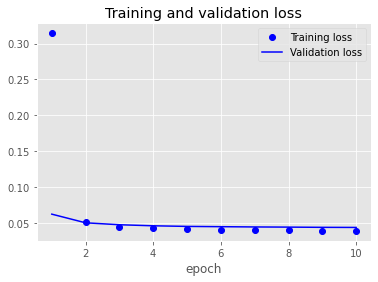

In [33]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*

embedding layer essentially maps our word vector (1-dimension) to a continuous multi-dimension (in our case 50) vector, so that the latter can reflect the simiilarity of words in our corpus.

In [34]:
n_words * 50

1758950

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*

number of unique words (n_words) * dimensions (50) =  1758950

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [35]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9348924101410195


array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat', 'PAD'], dtype=object)

In [36]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

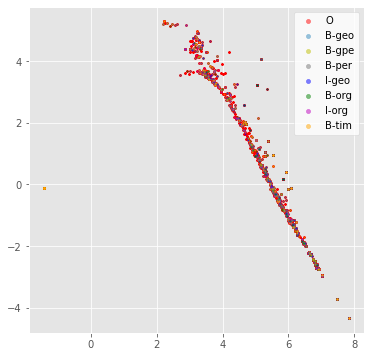

In [37]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [38]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [39]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.934892359406635


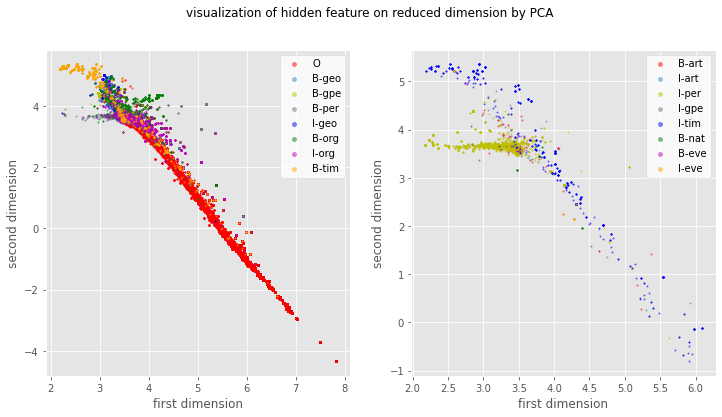

In [40]:
h = get_hidden_output_PCA(FFNN,X_test,y_test,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [52]:
# your code here

model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(SimpleRNN(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 113s 3ms/sample - loss: 0.1001 - accuracy: 0.9777 - val_loss: 0.0352 - val_accuracy: 0.9897
Epoch 2/10
38846/38846 [==============================] - 110s 3ms/sample - loss: 0.0298 - accuracy: 0.9913 - val_loss: 0.0302 - val_accuracy: 0.9910
Epoch 3/10
38846/38846 [==============================] - 115s 3ms/sample - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.0287 - val_accuracy: 0.9915
Epoch 4/10
38846/38846 [==============================] - 116s 3ms/sample - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.0280 - val_accuracy: 0.9916
Epoch 5/10
38846/38846 [==============================] - 119s 3ms/sample - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0280 - val_accuracy: 0.9916
Epoch 6/10
38846/38846 [==============================] - 130s 3ms/sample - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0278 - val_accuracy: 0.9917
Epoch 7/10
38846/38846 [===========================

In [53]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [54]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_9 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 104, 50)           5050      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 104, 18)           918       
Total params: 1,764,918
Trainable params: 1,764,918
Non-trainable params: 0
_________________________________________________________________
None


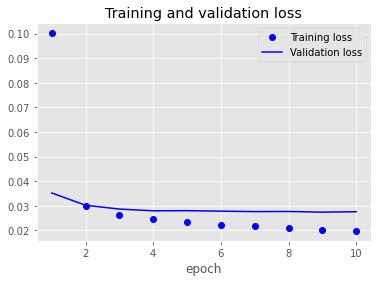

In [55]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

In [75]:
tags_b_i = [[], []]
for i, value in enumerate(tags): 
    if value.startswith('B-'): tags_b_i[0].append(i)
    if value.startswith('I-'): tags_b_i[1].append(i)

[[1, 2, 3, 5, 7, 8, 13, 14], [4, 6, 9, 10, 11, 12, 15, 16]]


Variance explained by PCA: 0.9833478563638458


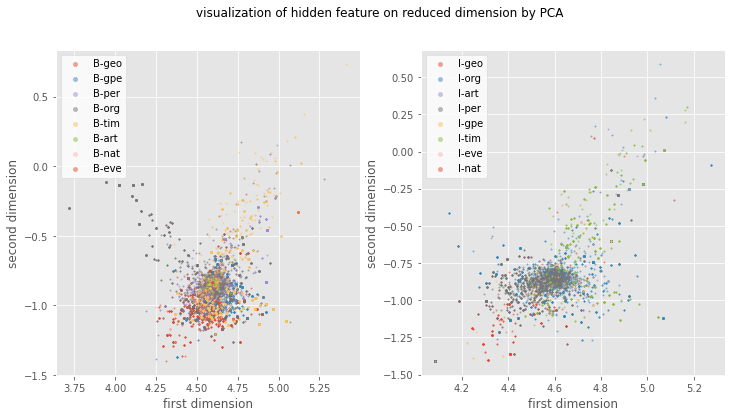

In [80]:
def visualize_intermediate(result):
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in tags_b_i[i]:
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], 
                          pca_result[indices, 1], 
                          label=idx2tag[cat],
                          s=2,
                          alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

pca_result = get_hidden_output_PCA(model,X_test,y_test,1,50)
visualize_intermediate(pca_result)

it appears that B and I are quite predictable by the main PCA factors.

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*

Gated Recurrent Units (GRU), and belongs to newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate.

GRU has 2 gates, and is a "simplified" LSTM. RNN doesn't have the forget and input concept. 

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [ ]:
# your code here

model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(GRU(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)


Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 244s 6ms/sample - loss: 0.1041 - accuracy: 0.9744 - val_loss: 0.0349 - val_accuracy: 0.9898
Epoch 2/10
38846/38846 [==============================] - 247s 6ms/sample - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0300 - val_accuracy: 0.9910
Epoch 3/10
38846/38846 [==============================] - 238s 6ms/sample - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0285 - val_accuracy: 0.9915
Epoch 4/10
 9920/38846 [======>.......................] - ETA: 2:51 - loss: 0.0238 - accuracy: 0.9930

In [ ]:
# save your model #
store_keras_model(model, 'model_GRU')

In [ ]:
# run this cell to show your results #
print(model.summary())

In [ ]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

In [ ]:
# your code here
pca_result = get_hidden_output_PCA(model,X_test,y_test,1,50)
visualize_intermediate(pca_result)

*your answer here*

similar results to RNN, but more focused.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



*your answer here*

In a bidirectional GRU, we consider 2 separate sequences. One from right to left and the other in the reverse order. this helps to consider the reverse word order, and combine that with the normal order to provide better results, especially in text processing.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [ ]:
# your code here

model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(Bidirectional(GRU(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)


In [ ]:
# save your model #
store_keras_model(model, 'model_BiGRU')

In [ ]:
# run this cell to show your results #
print(model.summary())

In [ ]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

In [ ]:
# your code here


*your answer here*

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [ ]:
# your code here


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

In [ ]:
# your code here


**3.3** Briefly discuss the performance of each model

*your answer here*


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

*your answer here*


**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [ ]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [ ]:
# your code here


In [ ]:
# your code here


In [ ]:
# your code here


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [ ]:
# your code here


**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*